In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import pyBigWig
import seaborn as sns
from IPython.core.display import HTML
from gscripts.general import dataviz

img_dir = "/home/bay001/projects/20151102_clip/data/splice_maps/"

In [2]:
class ReadDensity():
    """
    BigWig class
    Attributes:
        self.pos(positive *.bw file)
        self.neg(negative *.bw file)
    """
    def __init__(self, pos, neg):
        self.pos = pyBigWig.open(pos)
        self.neg = pyBigWig.open(neg)
    
    def values(self, chrom, start, end, strand):
        """
        Given a chromosome coordinate, return a list of values
        pertaining to the density over each nucleotide position
        
        Args:
            chrom (str): (eg. chr1)
            start (int): 0-based start (first position in chromosome is 0)
            end (int): 1-based end (last position is not included)
            strand (char): either '+' or '-'
        """
        try:
            if strand == "+":
                return self.pos.values(chrom, start, end)
            elif strand == "-":
                return list(reversed(self.neg.values(chrom, start, end)))
            else:
                raise("Strand neither + or -")
        except RuntimeError:
            return []*abs(start-end)

In [86]:
import collections

def some_range(rbp, interval, flank):
    
    if interval.strand == "+":
        wiggle = rbp.values(interval.chrom, interval.start - flank, interval.end + flank, interval.strand)
    elif interval.strand == "-":
        wiggle = rbp.values(interval.chrom, interval.start - flank, interval.end + flank, interval.strand)
    else:
        print "Strand not correct", interval.strand
        raise()
    return wiggle   

def get_single_frame_density(rbp,tsses_bt):
    densities_dict = collections.OrderedDict()
    densities = []
    for interval in tsses_bt:
        wiggle = some_range(rbp,interval,300)
        if not all(np.isnan(wiggle)):
            wiggle = pd.Series(wiggle)# .astype('float32')
            wiggle = np.nan_to_num(wiggle) # convert all nans to 0
            wiggle = [abs(w) for w in wiggle] # convert all values to positive
            pseudocount = min(i for i in wiggle if i > 0)
            wiggle = [w + pseudocount for w in wiggle] # add a minimum pseudocount
            """# print(pseudocount)
            
            interval_string = "{}:{}:{}:{}".format(
            interval.chrom,
            interval.start,
            interval.stop,
            interval.strand)
            densities_dict[interval_string] = wiggle"""
            densities.append(wiggle)
    densities = pd.DataFrame(densities)
    density_rowsums = densities.sum(axis=1)
    densities_div = densities.div(density_rowsums, axis=0) # divide each position by row total
    return densities, density_rowsums, densities_div, densities_div.mean() # return mean

In [87]:
rbfox2 = ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/204_01_RBFOX2.merged.r2.norm.pos.bw", 
                    neg="/projects/ps-yeolab2/encode/analysis/encode_v12/204_01_RBFOX2.merged.r2.norm.neg.bw")

fam120a = ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/279_01_FAM120A.merged.r2.norm.pos.bw", 
                    neg="/projects/ps-yeolab2/encode/analysis/encode_v12/279_01_FAM120A.merged.r2.norm.pos.bw")



In [90]:
# just add all the densities (pos and neg)
ddx3 = ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/350_01_DDX3X.merged.r2.norm.pos.bw", 
                    neg="/projects/ps-yeolab2/encode/analysis/encode_v12/350_01_DDX3X.merged.r2.norm.neg.bw")
img_dir = '/home/bay001/projects/maps_20160420/permanent_data/images/'
tsses = '/home/bay001/projects/maps_20160420/permanent_data/all_txEnd.bed'
tsses_bt = pybedtools.BedTool(tsses)
# with dataviz.Figure(os.path.join(img_dir, out_name), figsize=(5,5)) as fig:
densities, density_rowsums, densities_div, density_means = get_single_frame_density(ddx3,tsses_bt)
#density_sums = densities.sum(axis=0)

# plt.plot(density_means)
# densities
# df = pd.DataFrame(densities_dict).T
type(densities)
densities.values.nbytes

91539512

In [8]:
single_interval_1 = pd.DataFrame(some_range(ddx3,pybedtools.create_interval_from_list(['chr11', 76494103, 76494104, "0", "0", '-']),300)).fillna(0)
single_interval_2 = df.ix['chr11:76494103:76494104:-']
x = pd.concat([single_interval_1,single_interval_2],axis=1)
x[x[0]!=x['chr11:76494103:76494104:-']]

NameError: name 'df' is not defined

In [9]:
density_rowsums

/home/bay001/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/bay001/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


0     222.330078
1     243.554077
2     259.559059
3     242.510273
4     247.381355
5     235.203651
6     233.116045
7     220.590406
8     308.269875
9     257.471452
10    255.383846
dtype: float64

In [12]:
type(density_means)

pandas.core.series.Series

/home/bay001/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


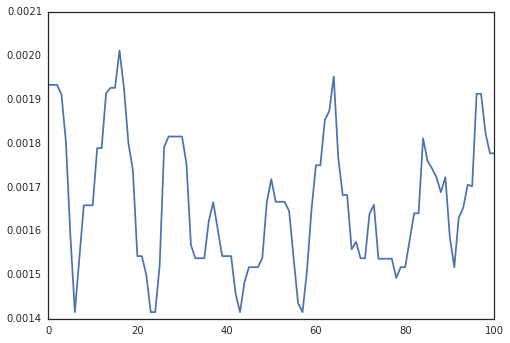

In [10]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n].mean()
l = (chunks(density_means,len(density_means)/100))
plt.plot(pd.Series(l))

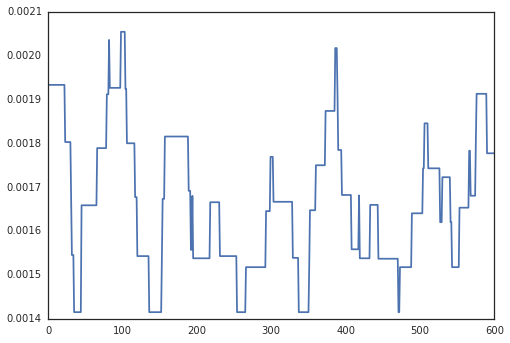

In [11]:
plt.plot(density_means)

In [196]:
tsses = '/home/bay001/projects/maps_20160420/permanent_data/all_txEnd.bed'
tsses_bt = pybedtools.BedTool(tsses)

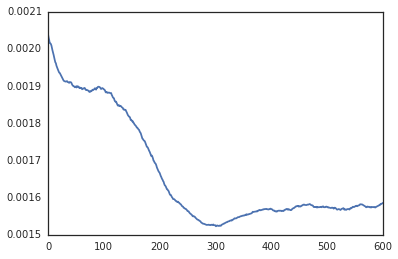

In [197]:
# just add all the densities (pos and neg)
ddx3 = ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/350_01_DDX3X.merged.r2.norm.pos.bw", 
                    neg="/projects/ps-yeolab2/encode/analysis/encode_v12/350_01_DDX3X.merged.r2.norm.neg.bw")
img_dir = '/home/bay001/projects/maps_20160420/permanent_data/images/'

# with dataviz.Figure(os.path.join(img_dir, out_name), figsize=(5,5)) as fig:
densities, density_rowsums, densities_div, density_means = get_single_frame_density(ddx3,tsses_bt)
#density_sums = densities.sum(axis=0)

plt.plot(density_means)
# densities
# density_rowsums

(0, 0.00185)

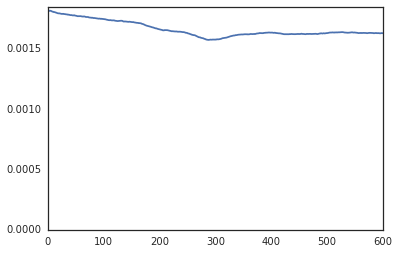

In [201]:
# just add all the densities (pos and neg)
rbfox2 = ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/204_01_RBFOX2.merged.r2.norm.pos.bw", 
                    neg="/projects/ps-yeolab2/encode/analysis/encode_v12/204_01_RBFOX2.merged.r2.norm.neg.bw")
img_dir = '/home/bay001/projects/maps_20160420/permanent_data/images/'

# with dataviz.Figure(os.path.join(img_dir, out_name), figsize=(5,5)) as fig:
densities, density_rowsums, densities_div, density_means = get_single_frame_density(rbfox2,tsses_bt)
#density_sums = densities.sum(axis=0)

plt.plot(density_means)
plt.ylim(0,0.00185)
# densities


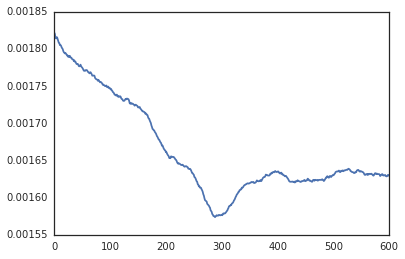

In [202]:
plt.plot(density_means)


In [9]:
# sums of absolute values and add minimum across each region
ddx3 = ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/350_01_DDX3X.merged.r2.norm.pos.bw", 
                    neg="/projects/ps-yeolab2/encode/analysis/encode_v12/350_01_DDX3X.merged.r2.norm.neg.bw")

out_name = 'ddx3x.txends.abs.add_min.svg'
img_dir = '/home/bay001/projects/maps_20160420/permanent_data/images/'

# with dataviz.Figure(os.path.join(img_dir, out_name), figsize=(5,5)) as fig:
densities = get_tss_map_densities_abs_and_add_min(ddx3,tsses_bt)
density_sums = densities.sum(axis=0)

# plt.plot(density_sums)
densities[600].sum()
# 
# densities

# plt.plot(density_sums)
# densities.sum(axis=0)

1.0438031852245331

/home/bay001/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


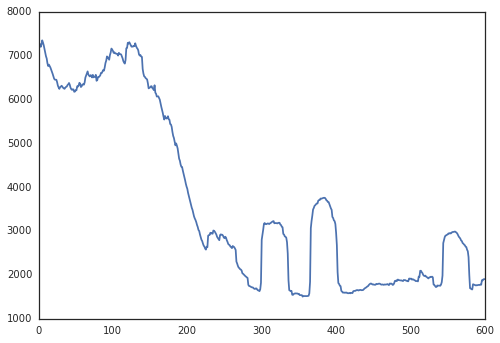

In [10]:
# sums of absolute values of densities
ddx3 = ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/350_01_DDX3X.merged.r2.norm.pos.bw", 
                    neg="/projects/ps-yeolab2/encode/analysis/encode_v12/350_01_DDX3X.merged.r2.norm.neg.bw")

tsses = '/home/bay001/projects/maps_20160420/permanent_data/all_txEnd.bed'
tsses_bt = pybedtools.BedTool(tsses)
out_name = 'ddx3x.txends.abs.add_min.svg'
img_dir = '/home/bay001/projects/maps_20160420/permanent_data/images/'

# with dataviz.Figure(os.path.join(img_dir, out_name), figsize=(5,5)) as fig:
density_sums = get_tss_map_densities_abs(ddx3,tsses_bt).sum(axis=0)
plt.plot(density_sums)


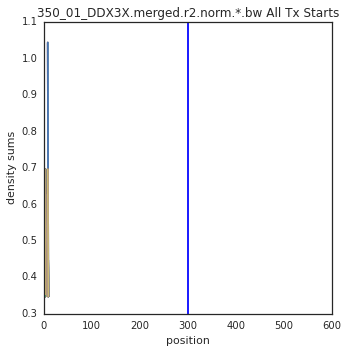

In [46]:
out_name = 'ddx3x.txends.sums.svg'
tsses = '/home/bay001/projects/maps_20160420/permanent_data/all_txEnd.100.bed'
tsses_bt = pybedtools.BedTool(tsses)
ddx3 = ReadDensity(pos="/projects/ps-yeolab2/encode/analysis/encode_v12/350_01_DDX3X.merged.r2.norm.pos.bw", 
                    neg="/projects/ps-yeolab2/encode/analysis/encode_v12/350_01_DDX3X.merged.r2.norm.neg.bw")

with dataviz.Figure(os.path.join(img_dir, out_name), figsize=(5,5)) as fig:
    density_sums = get_tss_map_densities(ddx3,tsses_bt,0)
    ax = fig.add_subplot(1,1,1)
    ax.plot(density_sums)
    ax.set_title('350_01_DDX3X.merged.r2.norm.*.bw All Tx Starts')
    ax.set_xlabel('position')
    ax.set_xticks([0,300,600],['upstream','tss', 'downstream'])
    ax.set_ylabel('density sums')
    ax.axvline(300)


In [62]:
get_tss_map_densities(ddx3,tsses_bt,0)

601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601


,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
get_tss_map_densities(ddx3,tsses_bt,0)

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.695869,0.695869,0.695869,0.695869,0.695869,0.695869,0.695869,0.695869,0.695869,0.695869
2,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.695869,0.695869,0.695869,0.695869,0.695869,0.695869,0.695869,0.695869,0.695869,0.695869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934,0.347934
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
out_name = 'ddx3x.txends.normed.svg'
tsses = '/home/bay001/projects/maps_20160420/permanent_data/all_txEnd.bed'
tsses_bt = pybedtools.BedTool(tsses)

with dataviz.Figure(os.path.join(img_dir, out_name), figsize=(5,5)) as fig:
    density_sums = get_tss_map_densities_div(ddx3,tsses_bt)
    ax = fig.add_subplot(1,1,1)
    ax.plot(density_sums)
    ax.set_title('350_01_DDX3X.merged.r2.norm.*.bw All Tx Starts')
    ax.set_xlabel('position')
    ax.set_xticks([0,300,600],['upstream','tss', 'downstream'])
    ax.set_ylabel('density sums')
    ax.axvline(300)

In [ ]:
out_name = 'ddx3x.txends.abs.add_min.svg'

with dataviz.Figure(os.path.join(img_dir, out_name), figsize=(5,5)) as fig:
    density_sums = get_tss_map_densities(ddx3,tsses_bt).sum(axis=0)
    ax = fig.add_subplot(1,1,1)
    ax.plot(density_sums)
    ax.set_title('350_01_DDX3X.merged.r2.norm.*.bw All Tx Ends')
    ax.set_xlabel('position')
    ax.set_xticks([0,300,600],['upstream','tss', 'downstream'])
    ax.set_ylabel('density sums')
    ax.axvline(300)

In [ ]:
out_name = 'fam120a.txstarts.svg'

with dataviz.Figure(os.path.join(img_dir, out_name), figsize=(5,5)) as fig:

    density_sums = get_tss_map_densities(fam120a,tsses_bt).sum(axis=0)
    ax = fig.add_subplot(1,1,1)
    plt.plot(density_sums)
    plt.title('279_01_FAM120A.merged.r2.norm.*.bw All Tx Starts')
    plt.xlabel('position')
    plt.xticks([0,300,600],['upstream','tss', 'downstream'])
    plt.ylabel('density sums')
    plt.axvline(300)